In [2]:
import os
import random
import shutil
from tqdm import tqdm
import cv2
import glob

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import random
from PIL import Image

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import f1_score

# 이미지 이동

In [3]:
data_root = '/Users/kimhongseok/cv_79_projects/part2/28/data'

train_root = f'{data_root}/train'
valid_root = f'{data_root}/valid'
test_root = f'{data_root}/test'

cls_list = os.listdir('/Users/kimhongseok/cv_79_projects/part2/28/AutoCrawler/download')

for folder in [train_root, valid_root, test_root]:
    # train, valid, test data 경로 생성
    if not os.path.exists(folder):
        os.makedirs(folder)
    # 각 폴더에 class 경로 생성 -> 박지성, 유해진
    for cls in cls_list:
        cls_folder = f'{folder}/{cls}'
        if not os.path.exists(cls_folder):
            os.makedirs(cls_folder)

In [4]:
random.seed(2025)

for cls in cls_list:
    file_list = os.listdir(f'/Users/kimhongseok/cv_79_projects/part2/28/AutoCrawler/download/{cls}') # 특정 클래스의 이미지 경로 모두 가져오기
    random.shuffle(file_list) # 이미지 랜덤하게 셔플
    test_ratio = 0.1
    num_file = len(file_list)

    test_list = file_list[:int(num_file*test_ratio)]
    valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
    train_list = file_list[int(num_file*test_ratio)*2:]

    for i in test_list:
        shutil.copyfile(f'/Users/kimhongseok/cv_79_projects/part2/28/AutoCrawler/download/{cls}/{i}', f'{test_root}/{cls}/{i}')
    for i in valid_list:
        shutil.copyfile(f'/Users/kimhongseok/cv_79_projects/part2/28/AutoCrawler/download/{cls}/{i}', f'{valid_root}/{cls}/{i}')
    for i in train_list:
        shutil.copyfile(f'/Users/kimhongseok/cv_79_projects/part2/28/AutoCrawler/download/{cls}/{i}', f'{train_root}/{cls}/{i}')

### 이미지 확인

In [5]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

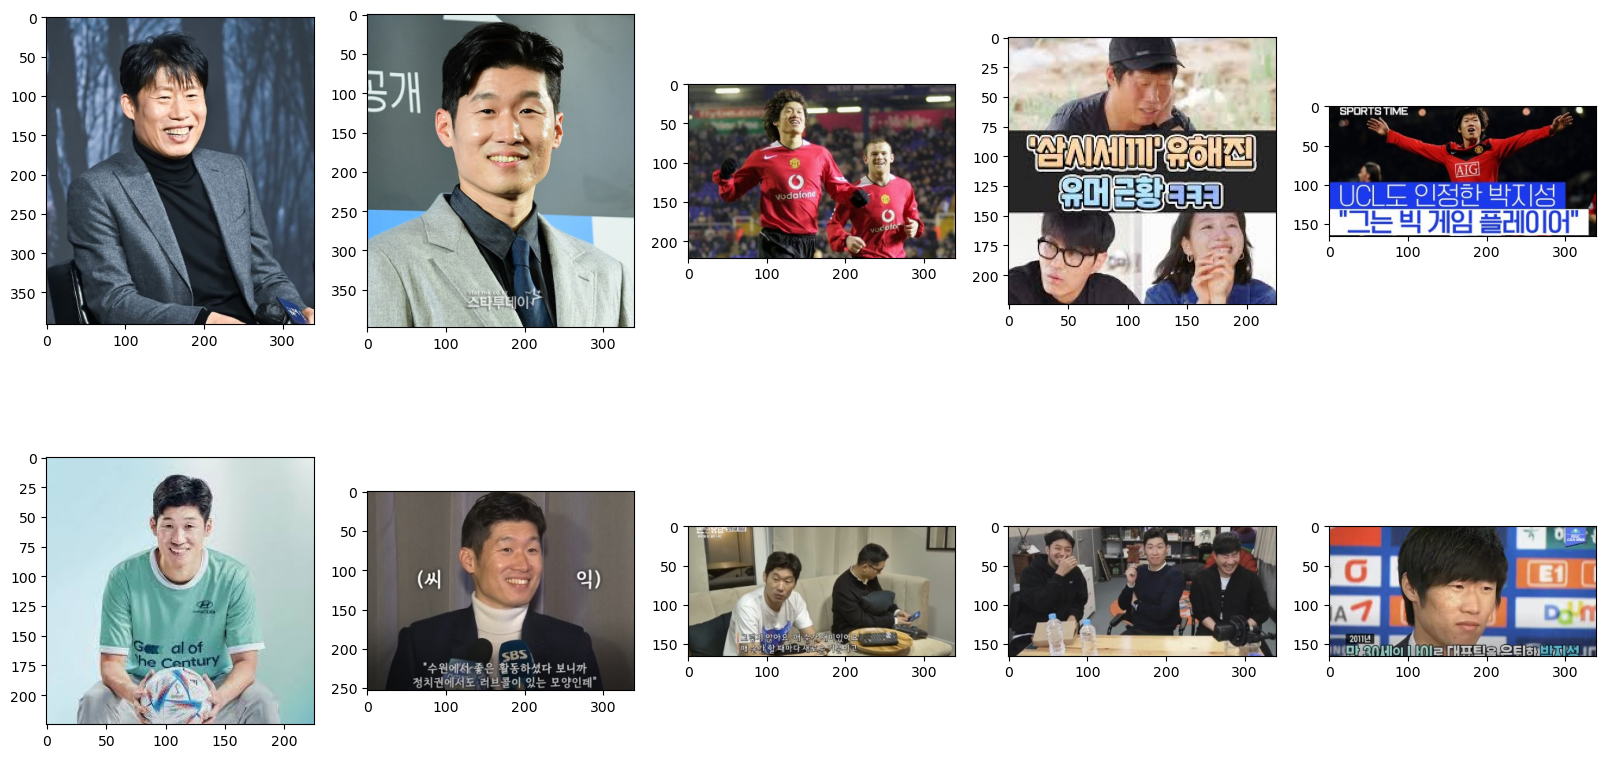

In [6]:
test_file_list = glob.glob(f'{test_root}/*/*')
random.shuffle(test_file_list)

plt.figure(figsize=(20, 10))
for i in range(10):
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(2, 5, i+1)
    plt.imshow(ori_img)

plt.show()

# CustomDataset

In [4]:
import torch
import torchvision
import  torchvision.transforms as T
import numpy as np

In [5]:
img_size = (224, 224)

data_transforms = {
    'train': T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, cls_list):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(cls_list):
            cls_dir = os.path.join(root, cls)
            img_list = os.listdir(cls_dir)
            for img in img_list:
                img_dir = os.path.join(cls_dir, img)
                self.data.append((img_dir, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [7]:
cls_list = ['유해진', '박지성']

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/28/data/train', data_transforms['train'], cls_list)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/28/data/valid', data_transforms['valid'], cls_list)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/28/data/test', data_transforms['test'], cls_list)

In [8]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

641 80 79


In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

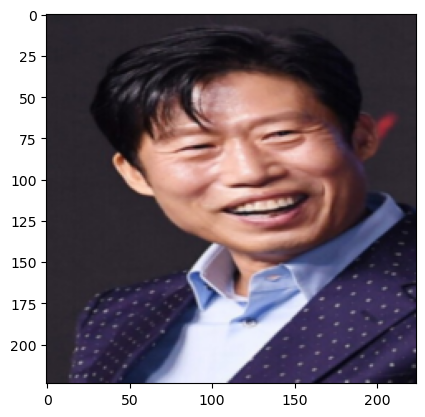

In [10]:
for tmp in train_dataloader:
    img = tmp[0][0].permute(1, 2, 0)
    plt.imshow(img)
    break

# Train, Evaluation

In [11]:
device = 'mps'

In [12]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss = loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy = (labels == preds).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset ,criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [13]:
model = timm.create_model(
    'resnet34',
    pretrained=True, 
    num_classes=2
)

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [31]:
'''
for params in model.parameters():
    params.require_grads = False

for params in model.layer4.parameters():
    params.require_grads = True

for params in model.fc.parameters():
    params.require_grads = True
'''

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 20)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.630097754575588, Train Accuracy: 0.7082683307332294, Valid Loss: 0.05463998913764954, Valid Accuracy: 0.075


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.4749651120768653, Train Accuracy: 0.828393135725429, Valid Loss: 0.03692777156829834, Valid Accuracy: 0.0625


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.35519913243658746, Train Accuracy: 0.8892355694227769, Valid Loss: 0.03132093846797943, Valid Accuracy: 0.075


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2650270288189252, Train Accuracy: 0.9157566302652106, Valid Loss: 0.031092897057533264, Valid Accuracy: 0.075


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.172886966003312, Train Accuracy: 0.953198127925117, Valid Loss: 0.02296077013015747, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.13175382518014053, Train Accuracy: 0.9641185647425897, Valid Loss: 0.020589296519756318, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.09630510744489269, Train Accuracy: 0.9750390015600624, Valid Loss: 0.014154976606369019, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.08176314920462945, Train Accuracy: 0.984399375975039, Valid Loss: 0.01651309132575989, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.07127717298306065, Train Accuracy: 0.982839313572543, Valid Loss: 0.01554461121559143, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.046996806006602665, Train Accuracy: 0.9921996879875195, Valid Loss: 0.02332232743501663, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0460572135232297, Train Accuracy: 0.9906396255850234, Valid Loss: 0.01695679873228073, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.04479860319801963, Train Accuracy: 0.9921996879875195, Valid Loss: 0.017084738612174986, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.028369507197589603, Train Accuracy: 0.9968798751950078, Valid Loss: 0.02006194144487381, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.020788541479024713, Train Accuracy: 1.0, Valid Loss: 0.018020293116569518, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.03045466319905065, Train Accuracy: 0.9968798751950078, Valid Loss: 0.02933950424194336, Valid Accuracy: 0.0875


  0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 